In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, ConfusionMatrixDisplay

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix

First 5 rows of the dataset:
    Area  Perimeter  Compactness  Kernel Length  Kernel Width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   Asymmetry Coefficient  Kernel Groove Length  Class  
0                  2.221                 5.220      1  
1                  1.018                 4.956      1  
2                  2.699                 4.825      1  
3                  2.259                 4.805      1  
4                  1.355                 5.175      1  

Missing values:
Area                     0
Perimeter                0
Compactness              0
Kernel Length            0
Kernel Width             0
Asymmetry Coefficient    0
Kernel Groove Length     0
Class                    0
dtype: int6

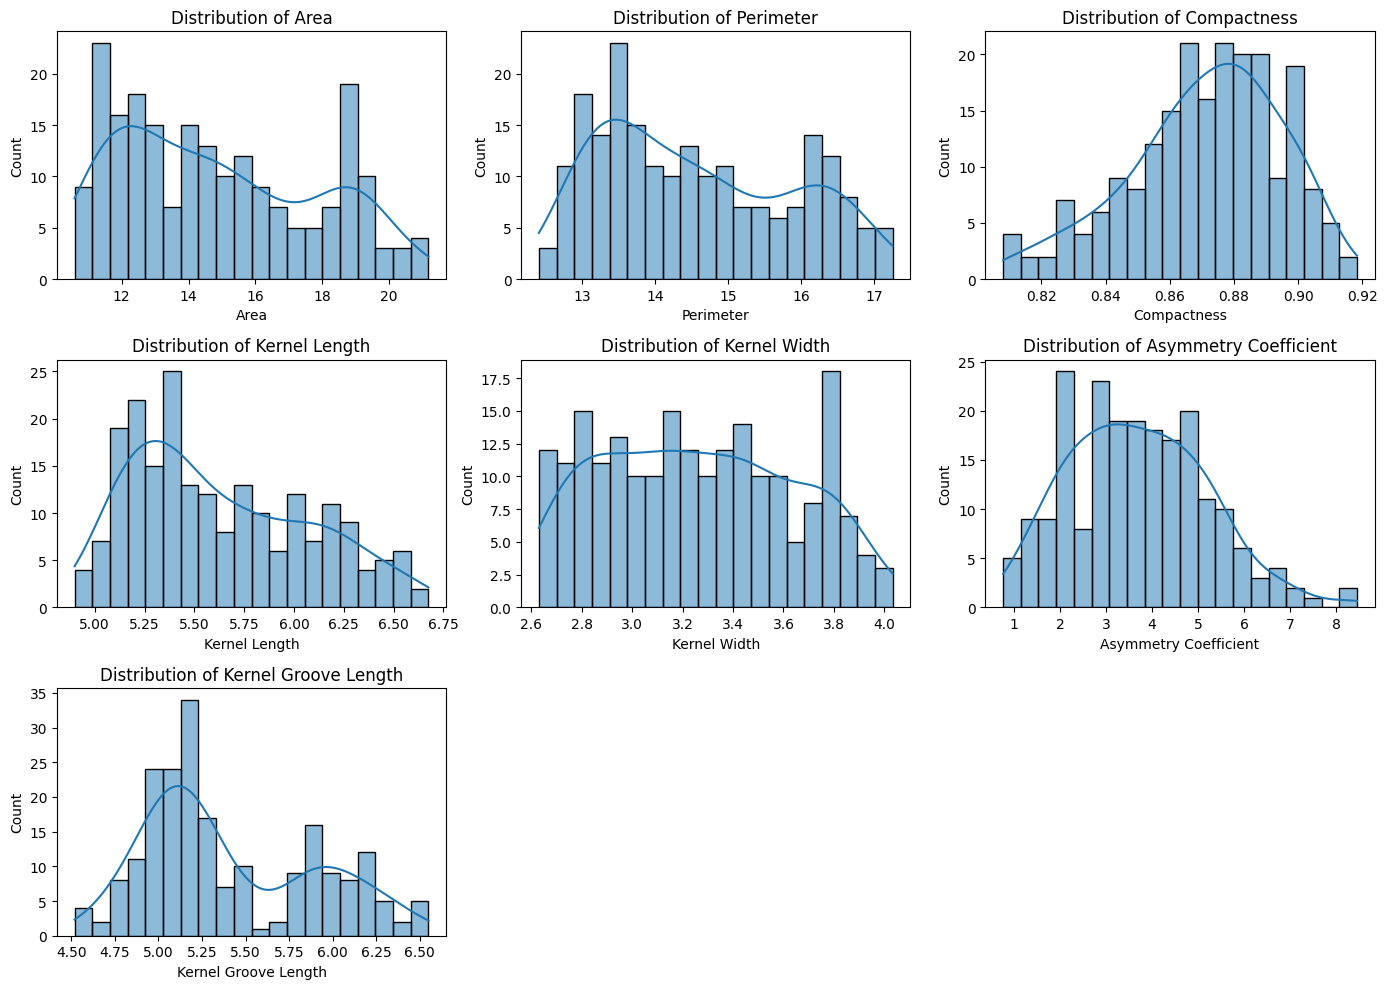

In [2]:

# -------------------------
# 1. Data Loading & Exploration
# -------------------------

# Load dataset
column_names = ['Area', 'Perimeter', 'Compactness', 'Kernel Length', 'Kernel Width', 'Asymmetry Coefficient', 'Kernel Groove Length', 'Class']
df = pd.read_csv('seeds_dataset.txt', sep='\s+', header=None, names=column_names)

# Show first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Visualize feature distributions
plt.figure(figsize=(14, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()




Explained variance ratio: [0.71874303 0.17108184]
Total explained variance by 2 components: 0.8898248618491231


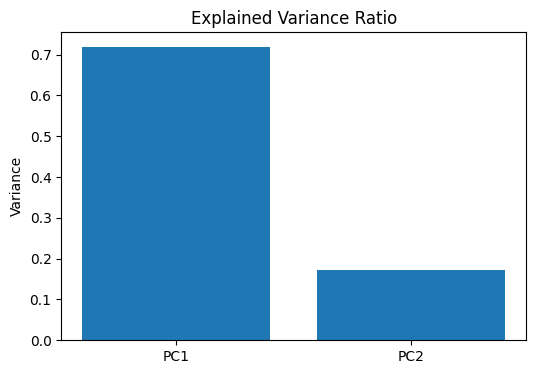

In [3]:
# -------------------------
# 2. Data Preprocessing
# -------------------------

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Class', axis=1))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"\nExplained variance ratio: {explained_variance}")
print(f"Total explained variance by 2 components: {np.sum(explained_variance)}")

# Plot PCA variance
plt.figure(figsize=(6,4))
plt.bar(range(1, 3), explained_variance, tick_label=["PC1", "PC2"])
plt.title("Explained Variance Ratio")
plt.ylabel("Variance")
plt.show()



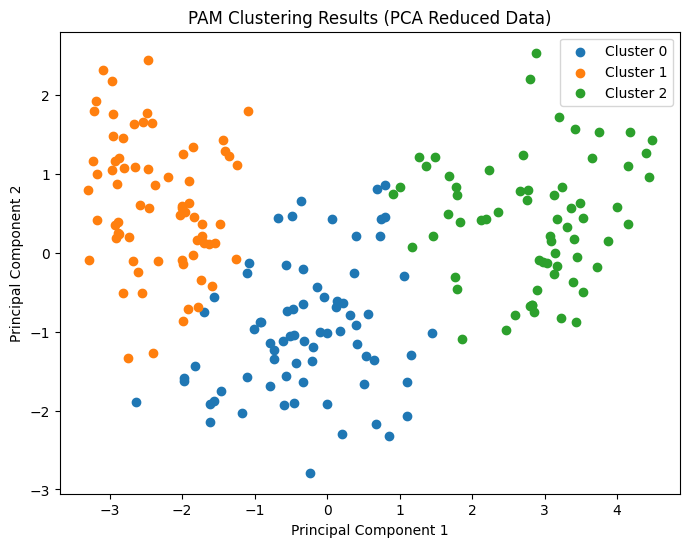

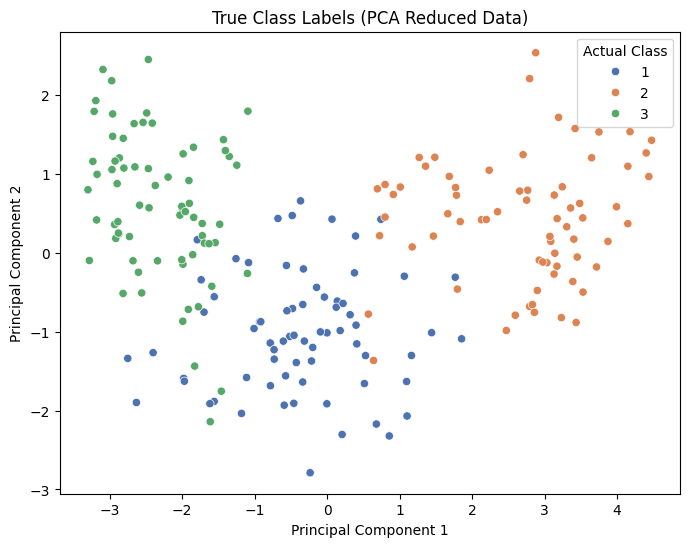

In [17]:
# -------------------------
# 3. Clustering with PAM
# -------------------------

# PAM needs distance matrix
distance_matrix = calculate_distance_matrix(X_pca)

# Choose initial medoids (randomly picking 3 unique indices)
initial_medoids = [0, 50, 100]  # One from each class (since dataset is sorted)

# Apply PAM clustering
pam_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
pam_instance.process()
clusters = pam_instance.get_clusters()
medoids = pam_instance.get_medoids()

# Prepare cluster labels for evaluation
cluster_labels = np.zeros(len(X_pca))
for i, cluster in enumerate(clusters):
    for index in cluster:
        cluster_labels[index] = i

# Plot the clustering result on PCA-transformed data
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title("PAM Clustering Results (PCA Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Overlay actual labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Class'], palette='deep')
plt.title("True Class Labels (PCA Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Actual Class')
plt.show()




Evaluation Metrics:
Silhouette Score: 0.4925
Adjusted Rand Index (ARI): 0.7723
Normalized Mutual Information (NMI): 0.7275


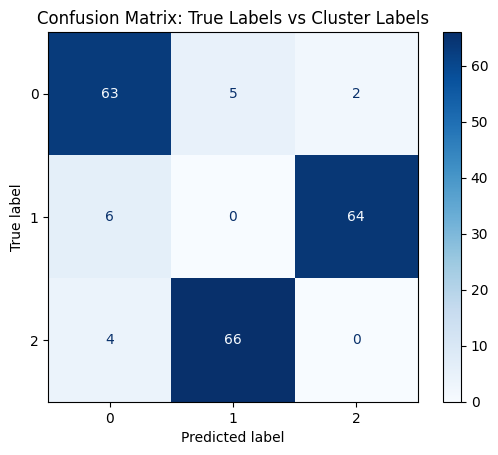

In [20]:
# -------------------------
# 4. Evaluation
# -------------------------

true_labels = df['Class'] - 1  # Classes are 1-indexed; convert to 0-indexed

silhouette = silhouette_score(X_pca, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("\nEvaluation Metrics:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, cluster_labels)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: True Labels vs Cluster Labels")
plt.show()



In [9]:
# -------------------------
# 5. Reporting
# -------------------------

print("\n--- Report Summary ---")
print("1. The dataset was successfully loaded, and no missing values were found.")
print("2. PCA reduced the features to 2 components, preserving {:.2f}% of the variance.".format(np.sum(explained_variance)*100))
print("3. PAM clustering divided the dataset into 3 clusters as expected.")
print("4. Evaluation Metrics:")
print(f"   - Silhouette Score: {silhouette:.4f}")
print(f"   - ARI: {ari:.4f}")
print(f"   - NMI: {nmi:.4f}")
print("5. Confusion Matrix shows reasonable alignment between clusters and actual classes.")
print("6. Challenges included selecting appropriate medoids and interpreting unsupervised cluster labels.")
print("7. Possible improvements:")
print("   - Try KMeans or DBSCAN for comparison.")
print("   - Tune medoid initialization or use ensemble clustering.")



--- Report Summary ---
1. The dataset was successfully loaded, and no missing values were found.
2. PCA reduced the features to 2 components, preserving 88.98% of the variance.
3. PAM clustering divided the dataset into 3 clusters as expected.
4. Evaluation Metrics:
   - Silhouette Score: 0.3992
   - ARI: 0.7078
   - NMI: 0.6760
5. Confusion Matrix shows reasonable alignment between clusters and actual classes.
6. Challenges included selecting appropriate medoids and interpreting unsupervised cluster labels.
7. Possible improvements:
   - Try KMeans or DBSCAN for comparison.
   - Tune medoid initialization or use ensemble clustering.
